In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from plot_functions import return_list, plot_chains, plot_chain_zscore

In [5]:
def plot_tvl_zscore(data_dict_all, chain_name, window_size=30, threshold=2):
    """
    Compute Z score for a single metric of a single chain and plot the anomaly detection chart.
    单独一个链的tvl'(tvl/price)Zscore以及异常图表绘制。因为其实我们不关心tvl的变化。
    Parameters:
    - data_dict_all (dict): all data of 150 days.
    - chain_name (str): name of the chain
    - metric (str): metric type ('fee', 'tvl', 'volume').
    - window_size (int): size of the rolling window, default 30.
    - threshold (int): z score threshold, default 2， we can also change it into 3.
    - include_price (bool): whether to include price data in the plot, default False.
    """
    
    # Ensure required data exists
    if 'tvl' not in data_dict_all or 'price' not in data_dict_all:
        print("Missing 'tvl' or 'price' data in the dataset.")
        return

    # Merge TVL and Price data
    tvl_df = data_dict_all['tvl'][chain_name].copy().tail(150)
    price_df = data_dict_all['price'][chain_name].copy().tail(150)
    merged_df = pd.merge(tvl_df, price_df, on='date', suffixes=('_tvl', '_price'))

    # Compute tvl'
    merged_df['tvl_prime'] = merged_df['value_tvl'] / merged_df['value_price'] / 1e6

    # Compute rolling statistics for tvl'
    merged_df['rolling_mean'] = merged_df['tvl_prime'].rolling(window=window_size).mean()
    merged_df['rolling_std'] = merged_df['tvl_prime'].rolling(window=window_size).std()
    merged_df['Z_score'] = (merged_df['tvl_prime'] - merged_df['rolling_mean']) / merged_df['rolling_std']
    merged_df['is_anomaly'] = merged_df['Z_score'].abs() > threshold

    # Select data for the last 365*2 days
    df_plot = merged_df.tail(365*2)

    # Plot the results
    plt.style.use('seaborn-v0_8')
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(df_plot['date'], df_plot['tvl_prime'], color='royalblue', linewidth=2.5, label="TVL'")
    ax1.plot(df_plot['date'], df_plot['rolling_mean'], color='orange', linestyle='--', linewidth=2, label=f'{window_size}-day Rolling Mean')

    # Mark anomalies
    anomalies = df_plot[df_plot['is_anomaly']]
    ax1.scatter(anomalies['date'], anomalies['tvl_prime'], color='red', s=60, edgecolor='black', label='Anomalies', zorder=5)

    # Add secondary y-axis for price
    ax2 = ax1.twinx()
    ax2.plot(df_plot['date'], df_plot['value_price'], color='green', linestyle='-', linewidth=2, label='Price')
    ax2.set_ylabel('Price', fontsize=14, fontweight='bold', color='green')
    ax2.tick_params(axis='y', labelsize=12, colors='green')

    # Axis labels and formatting
    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel("TVL'/Price (in B)", fontsize=14, fontweight='bold')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=12)
    ax1.grid(visible=True, linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper left', fontsize=12)
    # Format the left y-axis to show values with 'B'
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}m'))
    
    ax2.legend(loc='upper right', fontsize=12)

    # Title
    plt.title(f"{chain_name} TVL' Over Time with Z-Score Anomalies (Last 2 years)", fontsize=18, fontweight='bold')
    plt.tight_layout()

    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # plt.savefig(os.path.join(output_folder, f'{chain_name}_tvl.png'))
    # print(f"{chain_name} TVL' Z-Score chart with Price has been saved ({chain_name}_tvl_prime_zscore.png)")
    plt.show()
    plt.close()

         name           tvl
18   Ethereum  7.712145e+10
47     Solana  9.362328e+09
92       Tron  8.560568e+09
9         BSC  5.764599e+09
14       Base  3.964487e+09
54    Bitcoin  3.580065e+09
17   Arbitrum  3.415411e+09
95        Sui  1.674865e+09
15  Avalanche  1.604166e+09
59      Aptos  1.239431e+09
16    Polygon  1.177248e+09


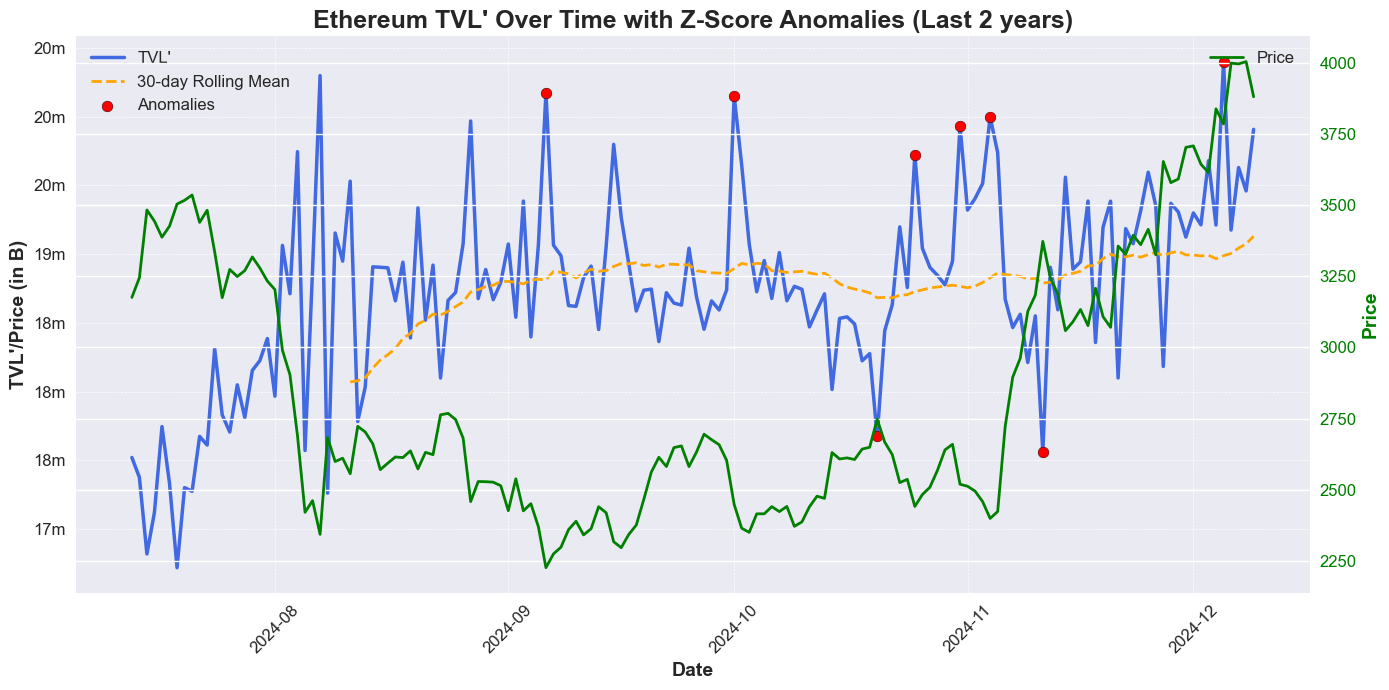

In [6]:
name_list = return_list() # get the name list of the chains

data_folder = 'data'
subfolders = ['fee', 'tvl', 'volume', 'price']

data_dict = {} # this one is for the last 120 days
data_dict_all = {} # this one is for all data, cuz we need to compute z-score

# read data
for subfolder in subfolders:
    folder_path = os.path.join(data_folder, subfolder)
    if os.path.exists(folder_path):
        csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

        data_dict[subfolder] = {}
        data_dict_all[subfolder] = {}

        for csv_file in csv_files:
            chain_name = csv_file.split('_')[1]

            csv_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(csv_path)

            df.columns = ['date', 'value'] if subfolder == 'fee' else ['date', subfolder]
            df.rename(columns={subfolder: 'value'}, inplace=True)
            df['date'] = pd.to_datetime(df['date'])

            data_dict[subfolder][chain_name] = df.tail(120)
            data_dict_all[subfolder][chain_name] = df


# for name in name_list['name']:
#     if name == 'Base':
#         continue
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='tvl', include_price=True)
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='fee', include_price=True)
    # plot_chain_zscore(data_dict_all, chain_name=name, metric='volume', include_price=True)

plot_tvl_zscore(data_dict_all, chain_name='Ethereum')

